# Car Insurance Claim Prediction
**Course:** Python for Data Science | ESIGELEC  
**Team:** *(fill in your names)*  
**Dataset:** `car_insurance.csv` — 10,000 rows × 18 columns  
**Goal:** Supervised binary classification — predict whether a customer will file a car insurance claim (`outcome = 1`) or not (`outcome = 0`).

---
## Step 1 — Import Libraries & Load Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, KFold,
                                     cross_val_score, GridSearchCV)
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score,
                              recall_score, f1_score, classification_report)
from sklearn.pipeline import Pipeline

# Display settings
pd.set_option('display.max_columns', 20)
pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_theme(style='whitegrid')

# ── Load dataset ──────────────────────────────────────────────────────────────
df = pd.read_csv('car_insurance.csv')

print("=" * 50)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print("=" * 50)
df.info()


Shape: 10000 rows × 18 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10000 non-null  int64  
 1   age                  10000 non-null  int64  
 2   gender               10000 non-null  int64  
 3   driving_experience   10000 non-null  object 
 4   education            10000 non-null  object 
 5   income               10000 non-null  object 
 6   credit_score         9018 non-null   float64
 7   vehicle_ownership    10000 non-null  float64
 8   vehicle_year         10000 non-null  object 
 9   married              10000 non-null  float64
 10  children             10000 non-null  float64
 11  postal_code          10000 non-null  int64  
 12  annual_mileage       9043 non-null   float64
 13  vehicle_type         10000 non-null  object 
 14  speeding_violations  10000 non-null  int64  
 15  duis  

In [3]:
# First rows
df.head()


,id,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,postal_code,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,569520,3,0,0-9y,high school,upper class,0.6290,1.0000,after 2015,0.0000,1.0000,10238,12000.0000,sedan,0,0,0,0.0000
1,750365,0,1,0-9y,none,poverty,0.3578,0.0000,before 2015,0.0000,0.0000,10238,16000.0000,sedan,0,0,0,1.0000
2,199901,0,0,0-9y,high school,working class,0.4931,1.0000,before 2015,0.0000,0.0000,10238,11000.0000,sedan,0,0,0,0.0000
3,478866,0,1,0-9y,university,working class,0.2060,1.0000,before 2015,0.0000,1.0000,32765,11000.0000,sedan,0,0,0,0.0000
4,731664,1,1,10-19y,none,working class,0.3884,1.0000,before 2015,0.0000,0.0000,32765,12000.0000,sedan,2,0,1,1.0000


In [4]:
# Summary statistics
df.describe()


,id,age,gender,credit_score,vehicle_ownership,married,children,postal_code,annual_mileage,speeding_violations,duis,past_accidents,outcome
count,10000.0000,10000.0000,10000.0000,9018.0000,10000.0000,10000.0000,10000.0000,10000.0000,9043.0000,10000.0000,10000.0000,10000.0000,10000.0000
mean,500521.9068,1.4895,0.4990,0.5158,0.6970,0.4983,0.7086,19864.5484,11697.0032,7.7875,0.2392,1.0563,0.3133
std,290030.7688,1.0253,0.5000,0.1377,0.4596,0.5000,1.3504,18915.6139,2818.4345,434.0389,0.5550,1.6525,0.4639
min,101.0000,0.0000,0.0000,0.0534,0.0000,0.0000,0.0000,10238.0000,2000.0000,0.0000,0.0000,0.0000,0.0000
25%,249638.5000,1.0000,0.0000,0.4172,0.0000,0.0000,0.0000,10238.0000,10000.0000,0.0000,0.0000,0.0000,0.0000
50%,501777.0000,1.0000,0.0000,0.5250,1.0000,0.0000,1.0000,10238.0000,12000.0000,0.0000,0.0000,0.0000,0.0000
75%,753974.5000,2.0000,1.0000,0.6183,1.0000,1.0000,1.0000,32765.0000,14000.0000,2.0000,0.0000,2.0000,1.0000
max,999976.0000,3.0000,1.0000,0.9608,1.0000,1.0000,103.0000,92101.0000,22000.0000,41056.0000,6.0000,15.0000,1.0000


---
## Step 2 — Data Review

**Objective:** Identify qualitative data, missing values, and outliers.

> **Report questions:**
> - Which variables are qualitative? Which are quantitative?
> - Which columns have missing values, and how many?
> - Which numerical variables show outliers in the box plots?

In [5]:
# ── 2.1  Qualitative vs quantitative columns ─────────────────────────────────
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include='number').columns.tolist()

print("Qualitative (categorical) columns:", cat_cols)
print("\nQuantitative (numerical) columns :", num_cols)
print("\nUnique values per categorical column:")
print(df[cat_cols].nunique())


Qualitative (categorical) columns: ['driving_experience', 'education', 'income', 'vehicle_year', 'vehicle_type']

Quantitative (numerical) columns : ['id', 'age', 'gender', 'credit_score', 'vehicle_ownership', 'married', 'children', 'postal_code', 'annual_mileage', 'speeding_violations', 'duis', 'past_accidents', 'outcome']

Unique values per categorical column:
driving_experience    4
education             3
income                4
vehicle_year          2
vehicle_type          2
dtype: int64


In [6]:
# ── 2.2  Missing values ───────────────────────────────────────────────────────
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0]
print("Columns with missing values:")
print(missing_df)


Columns with missing values:
                Missing Count  Missing %
credit_score              982     9.8200
annual_mileage            957     9.5700


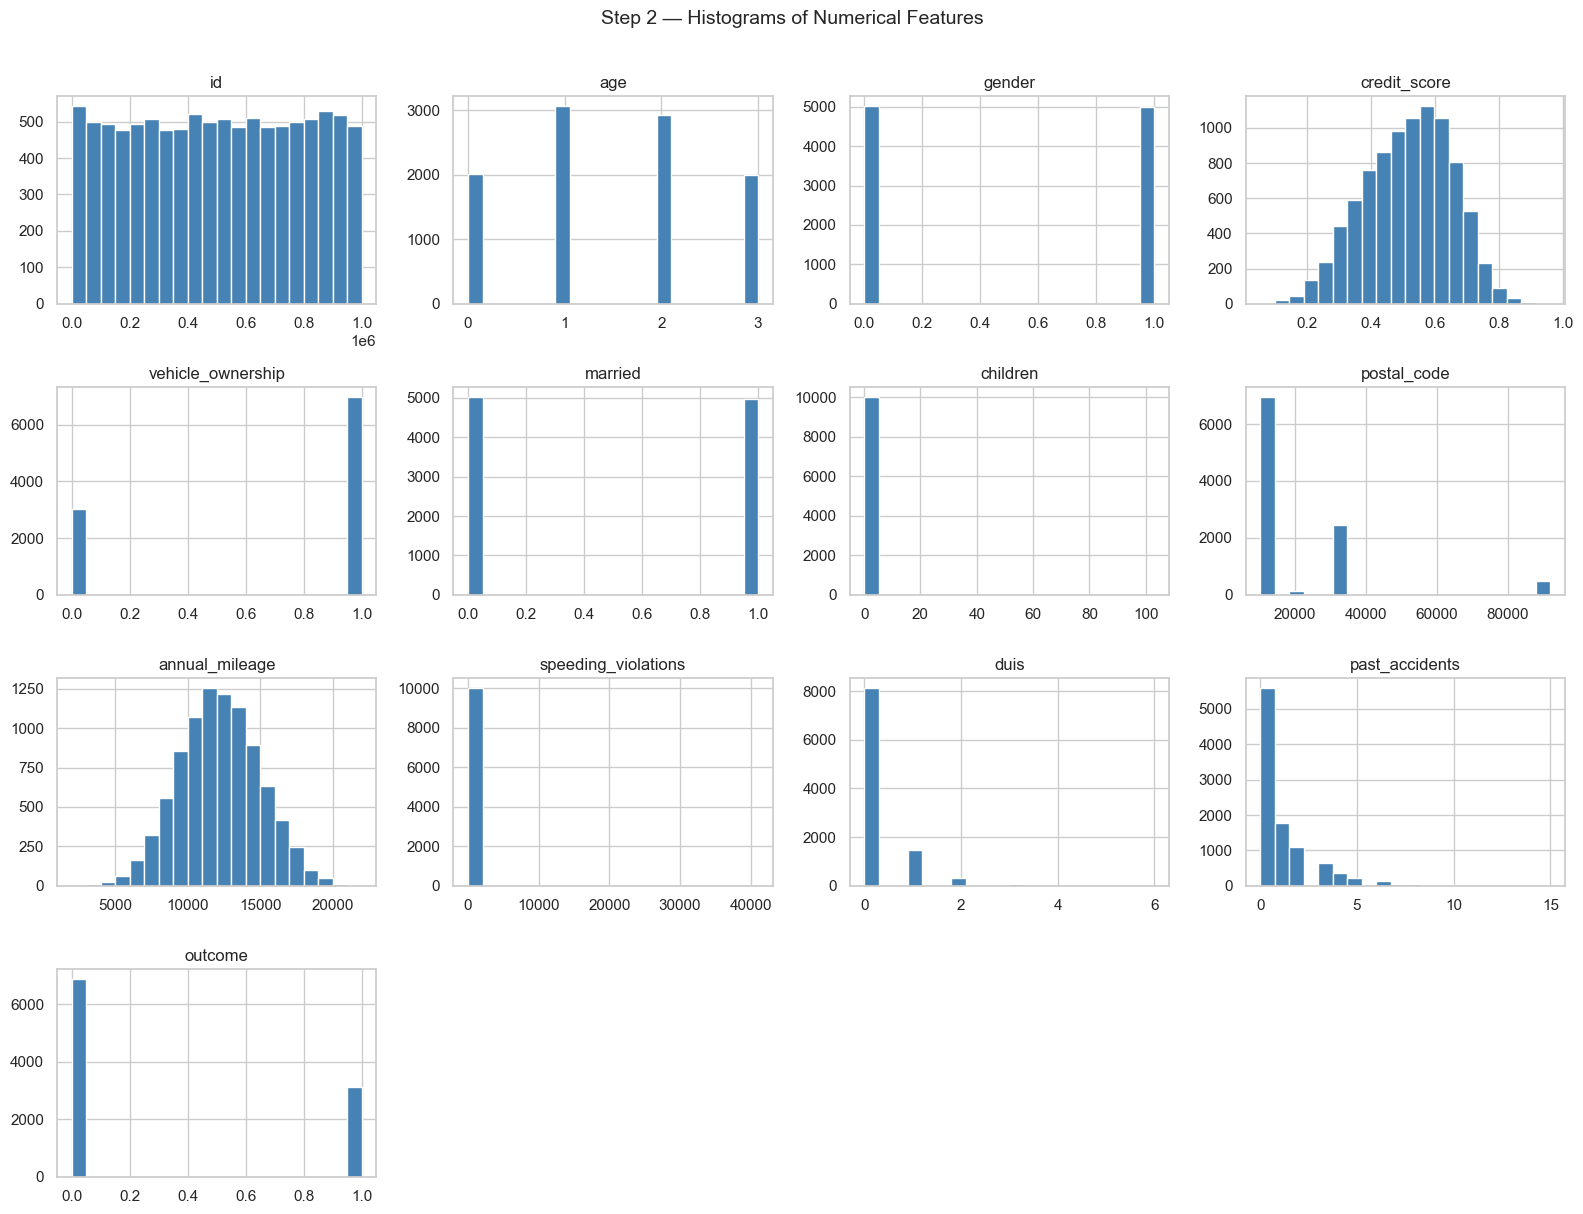

In [7]:
# ── 2.3  Histograms — distributions of all numerical features ─────────────────
df.hist(figsize=(16, 12), bins=20, color='steelblue', edgecolor='white')
plt.suptitle('Step 2 — Histograms of Numerical Features', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()


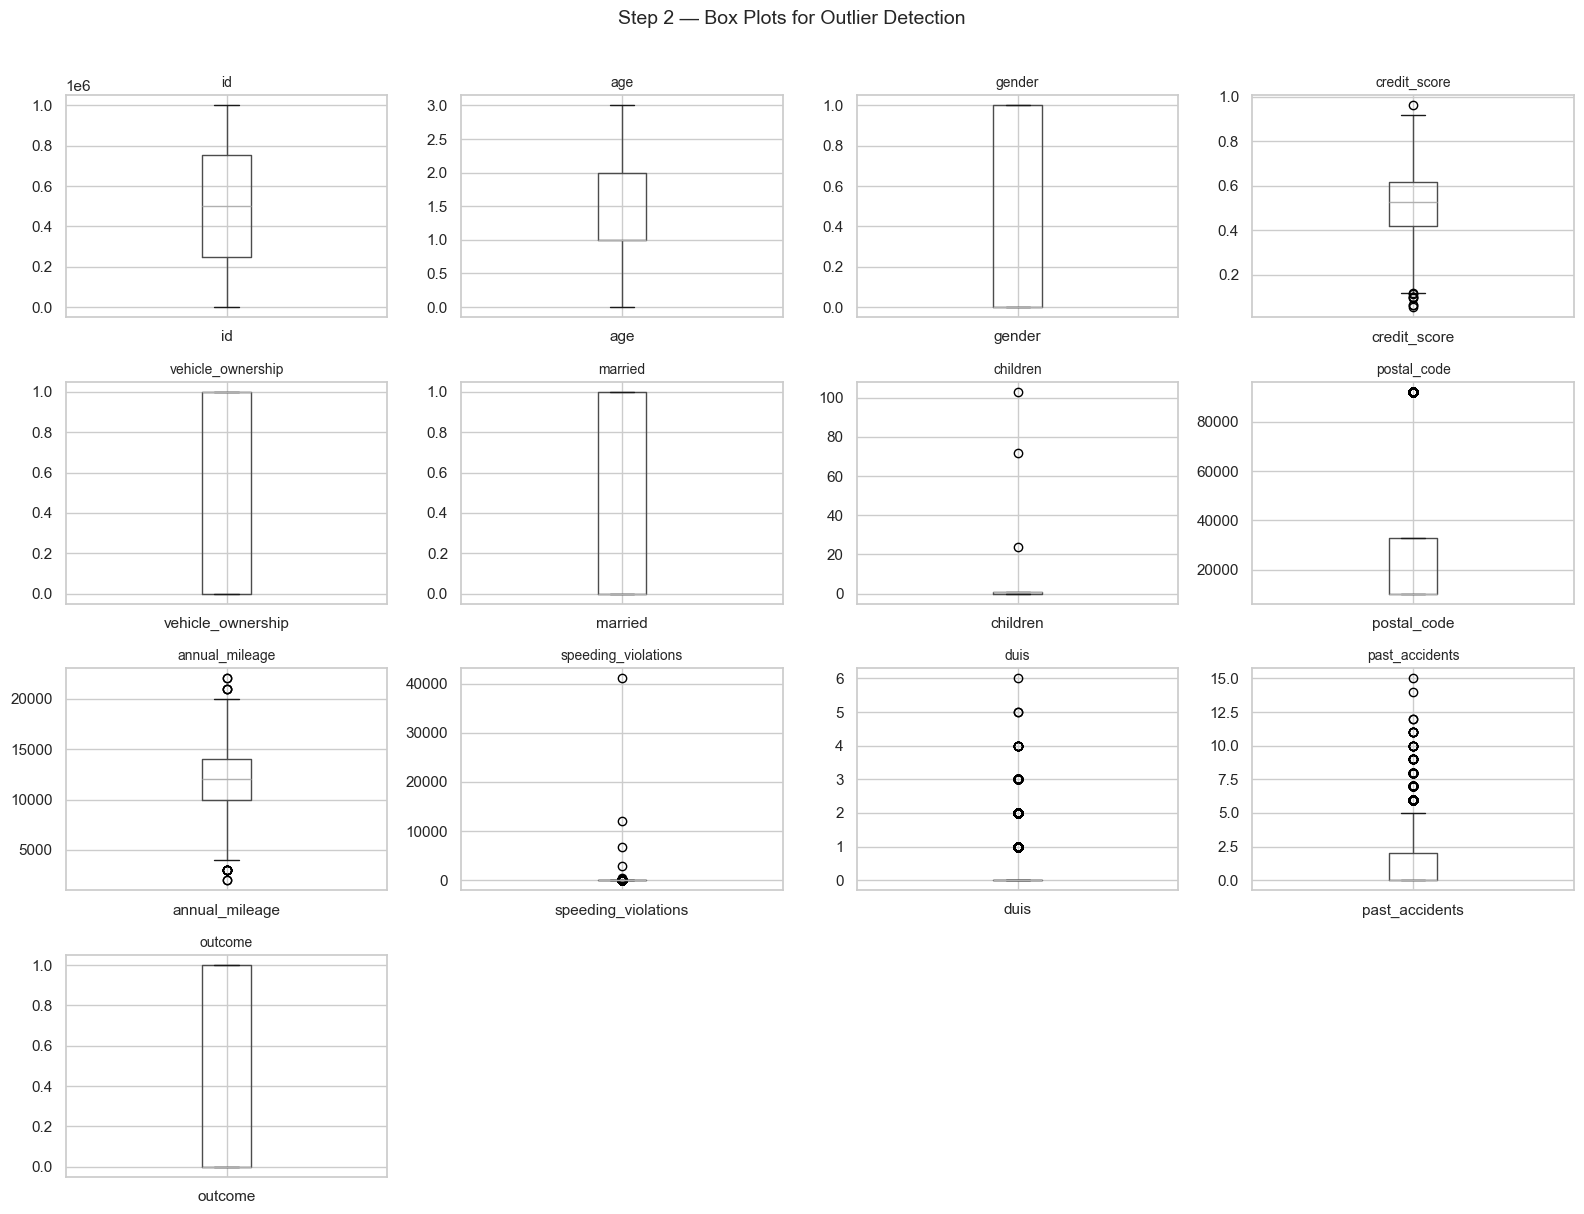

In [8]:
# ── 2.4  Box plots — outlier detection ───────────────────────────────────────
num_cols_plot = df.select_dtypes(include='number').columns.tolist()
n = len(num_cols_plot)
cols_per_row = 4
rows = (n + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(rows, cols_per_row, figsize=(16, rows * 3))
axes = axes.flatten()

for i, col in enumerate(num_cols_plot):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col, fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Step 2 — Box Plots for Outlier Detection', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()


---
## Step 3 — Data Preparation

### 3.1 — Remove Irrelevant Columns
`id` is a unique identifier with no predictive power. `postal_code` has high cardinality with no ordinal meaning — both are dropped.

In [ ]:
# ── 3.1  Drop irrelevant columns ─────────────────────────────────────────────
df = df.drop(columns=['id', 'postal_code'])
print(f"Shape after dropping irrelevant columns: {df.shape}")

Shape after dropping irrelevant columns: (10000, 16)


### 3.2 — Handle Missing Values

**Rule:** Drop a column if **> 1/3 (33%)** of values are missing. Otherwise impute.
- `credit_score`: 9.8% missing → impute with **median** (numerical, right-skewed)
- `annual_mileage`: 9.6% missing → impute with **median**

In [10]:
# ── 3.2  Missing value handling — 1/3 rule ───────────────────────────────────
missing_ratio = df.isna().sum() / len(df)
print("Missing ratios per column (only those > 0):")
print(missing_ratio[missing_ratio > 0].apply(lambda x: f"{x*100:.2f}%"))
print("\n1/3 threshold = 33.3%")
print("→ All missing columns are well below the threshold → IMPUTE with median")

df['credit_score']   = df['credit_score'].fillna(df['credit_score'].median())
df['annual_mileage'] = df['annual_mileage'].fillna(df['annual_mileage'].median())

print("\nRemaining missing values after imputation:")
print(df.isna().sum()[df.isna().sum() > 0])
print("✓ No missing values remain." if df.isna().sum().sum() == 0 else "⚠ Some missing values remain.")


Missing ratios per column (only those > 0):
credit_score      9.82%
annual_mileage    9.57%
dtype: object

1/3 threshold = 33.3%
→ All missing columns are well below the threshold → IMPUTE with median

Remaining missing values after imputation:
Series([], dtype: int64)
✓ No missing values remain.


### 3.3 — Handle Outliers

Outliers (identified in Step 2 box plots) are **capped** using the IQR method:  
- Replace values **below** Q1 − 1.5×IQR with the lower bound  
- Replace values **above** Q3 + 1.5×IQR with the upper bound  

This preserves the row count while removing extreme values.

  speeding_violations: capped
  duis: capped
  past_accidents: capped
  annual_mileage: capped

Box plots after outlier capping:


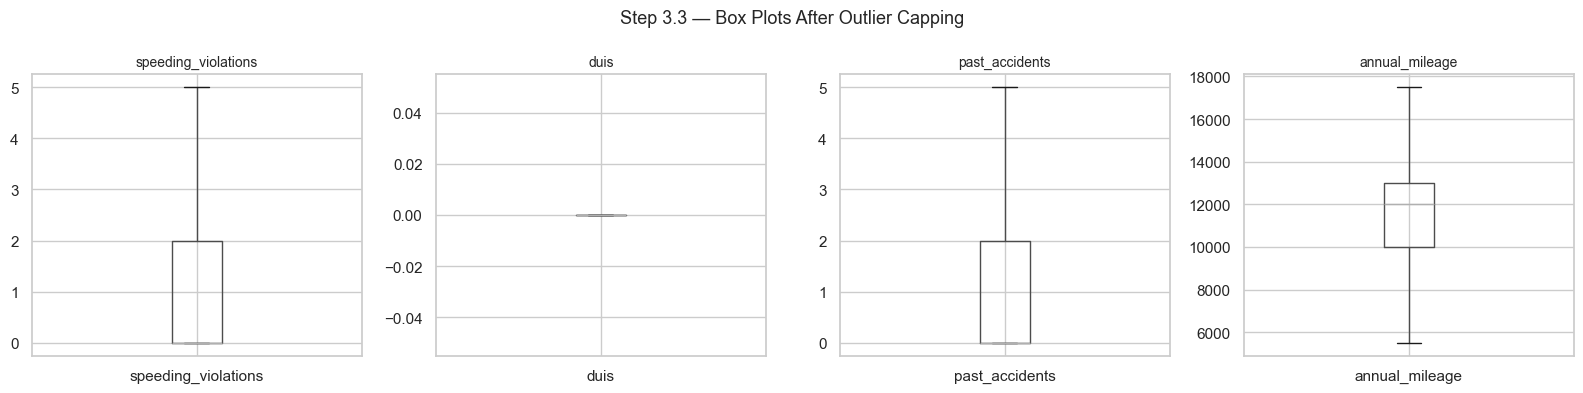

In [11]:
# ── 3.3  Outlier capping — IQR method ────────────────────────────────────────
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower=lower, upper=upper)

outlier_cols = ['speeding_violations', 'duis', 'past_accidents', 'annual_mileage']
for col in outlier_cols:
    df[col] = cap_outliers(df[col])
    print(f"  {col}: capped")

print("\nBox plots after outlier capping:")
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for ax, col in zip(axes, outlier_cols):
    df.boxplot(column=col, ax=ax)
    ax.set_title(col, fontsize=10)
plt.suptitle('Step 3.3 — Box Plots After Outlier Capping', fontsize=13)
plt.tight_layout()
plt.show()


### 3.4 — Encode Categorical Variables

**Rule from the project:**
- **`replace()`** for boolean/binary columns (2 unique values) — direct, deterministic mapping
- **`LabelEncoder`** for multi-class ordinal columns — automatically encodes string labels to integers

> **Why this distinction?** `replace()` lets us control the exact ordinal order. `LabelEncoder` is convenient when order can be inferred or when we just need numeric codes. For nominal variables, one-hot encoding would be preferred, but the project specification uses `LabelEncoder`.

In [28]:
# ── 3.4  Categorical encoding ─────────────────────────────────────────────────

# Boolean/binary → replace() with explicit mapping
df['vehicle_year'] = df['vehicle_year'].replace({'before 2015': 0, 'after 2015': 1})
df['vehicle_type'] = df['vehicle_type'].replace({'sedan': 0, 'sports car': 1})
print("Boolean columns encoded with replace():")
print("  vehicle_year : {'before 2015': 0, 'after 2015': 1}")
print("  vehicle_type : {'sedan': 0, 'sports car': 1}")

# Multi-class ordinal → LabelEncoder
le = LabelEncoder()
label_cols = ['driving_experience', 'education', 'income']
for col in label_cols:
    original_values = sorted(df[col].unique())
    df[col] = le.fit_transform(df[col])
    print(f"\n  {col} encoded: \n {original_values} \n → {list(range(len(original_values)))}")

# Verify all columns are now numeric
print("\nColumn dtypes after encoding:")
print(df.dtypes)
print("\nSample rows:")
df.head(3)


Boolean columns encoded with replace():
  vehicle_year : {'before 2015': 0, 'after 2015': 1}
  vehicle_type : {'sedan': 0, 'sports car': 1}

  driving_experience encoded: 
 [np.int64(0), np.int64(1), np.int64(2), np.int64(3)] 
 → [0, 1, 2, 3]

  education encoded: 
 [np.int64(0), np.int64(1), np.int64(2)] 
 → [0, 1, 2]

  income encoded: 
 [np.int64(0), np.int64(1), np.int64(2), np.int64(3)] 
 → [0, 1, 2, 3]

Column dtypes after encoding:
age                      int64
gender                   int64
driving_experience       int64
education                int64
income                   int64
credit_score           float64
vehicle_ownership      float64
vehicle_year             int64
married                float64
children               float64
annual_mileage         float64
vehicle_type             int64
speeding_violations      int64
duis                     int64
past_accidents           int64
outcome                float64
dtype: object

Sample rows:


,age,gender,driving_experience,education,income,credit_score,vehicle_ownership,vehicle_year,married,children,annual_mileage,vehicle_type,speeding_violations,duis,past_accidents,outcome
0,3,0,0,0,2,0.6290,1.0000,1,0.0000,1.0000,12000.0000,0,0,0,0,0.0000
1,0,1,0,1,1,0.3578,0.0000,0,0.0000,0.0000,16000.0000,0,0,0,0,1.0000
2,0,0,0,0,3,0.4931,1.0000,0,0.0000,0.0000,11000.0000,0,0,0,0,0.0000


---
## Step 4 — Search for Correlations

**Objective:** Identify which inputs correlate most with the target and with each other.

> **Report questions:**
> - Which input variable is **most correlated** with `outcome`?
> - Are there pairs of inputs strongly correlated with each other? What is the **multicollinearity** risk?
> - What do the scatter plots reveal about feature relationships?

Correlation with 'outcome' (sorted descending):
outcome                1.0000
annual_mileage         0.1771
gender                 0.1072
vehicle_type           0.0056
income                -0.0476
children              -0.0581
education             -0.0926
married               -0.2618
vehicle_year          -0.2942
credit_score          -0.3090
past_accidents        -0.3307
speeding_violations   -0.3317
vehicle_ownership     -0.3789
age                   -0.4485
driving_experience    -0.4974
duis                      NaN


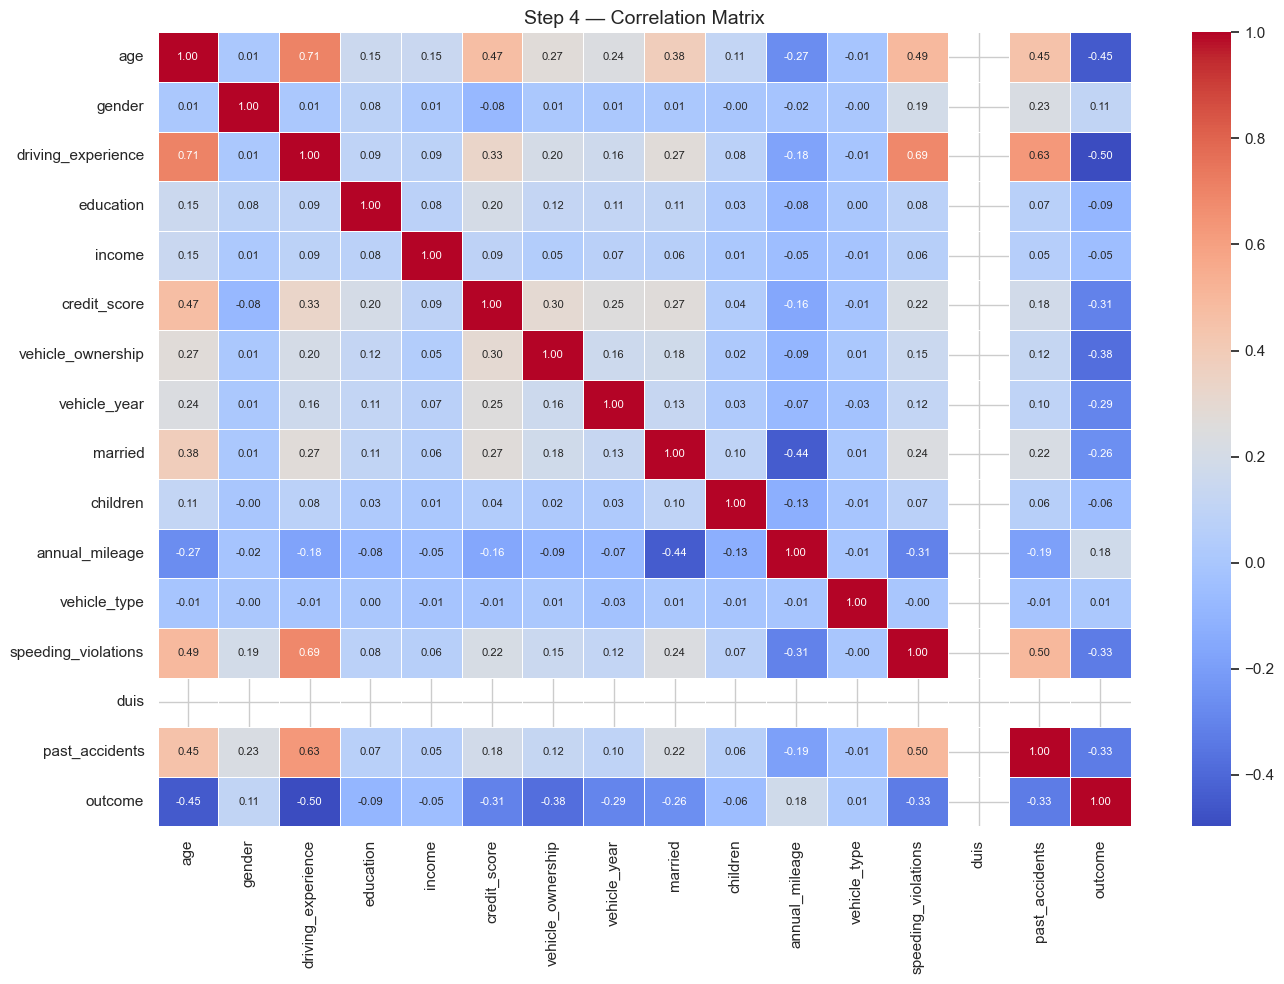

In [13]:
# ── 4.1  Correlation matrix ───────────────────────────────────────────────────
corr = df.corr()

print("Correlation with 'outcome' (sorted descending):")
print(corr['outcome'].sort_values(ascending=False).to_string())

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm',
            linewidths=0.5, annot_kws={'size': 8})
plt.title('Step 4 — Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()


Top features by |correlation| with outcome: ['outcome', 'driving_experience', 'age', 'vehicle_ownership', 'speeding_violations', 'past_accidents']


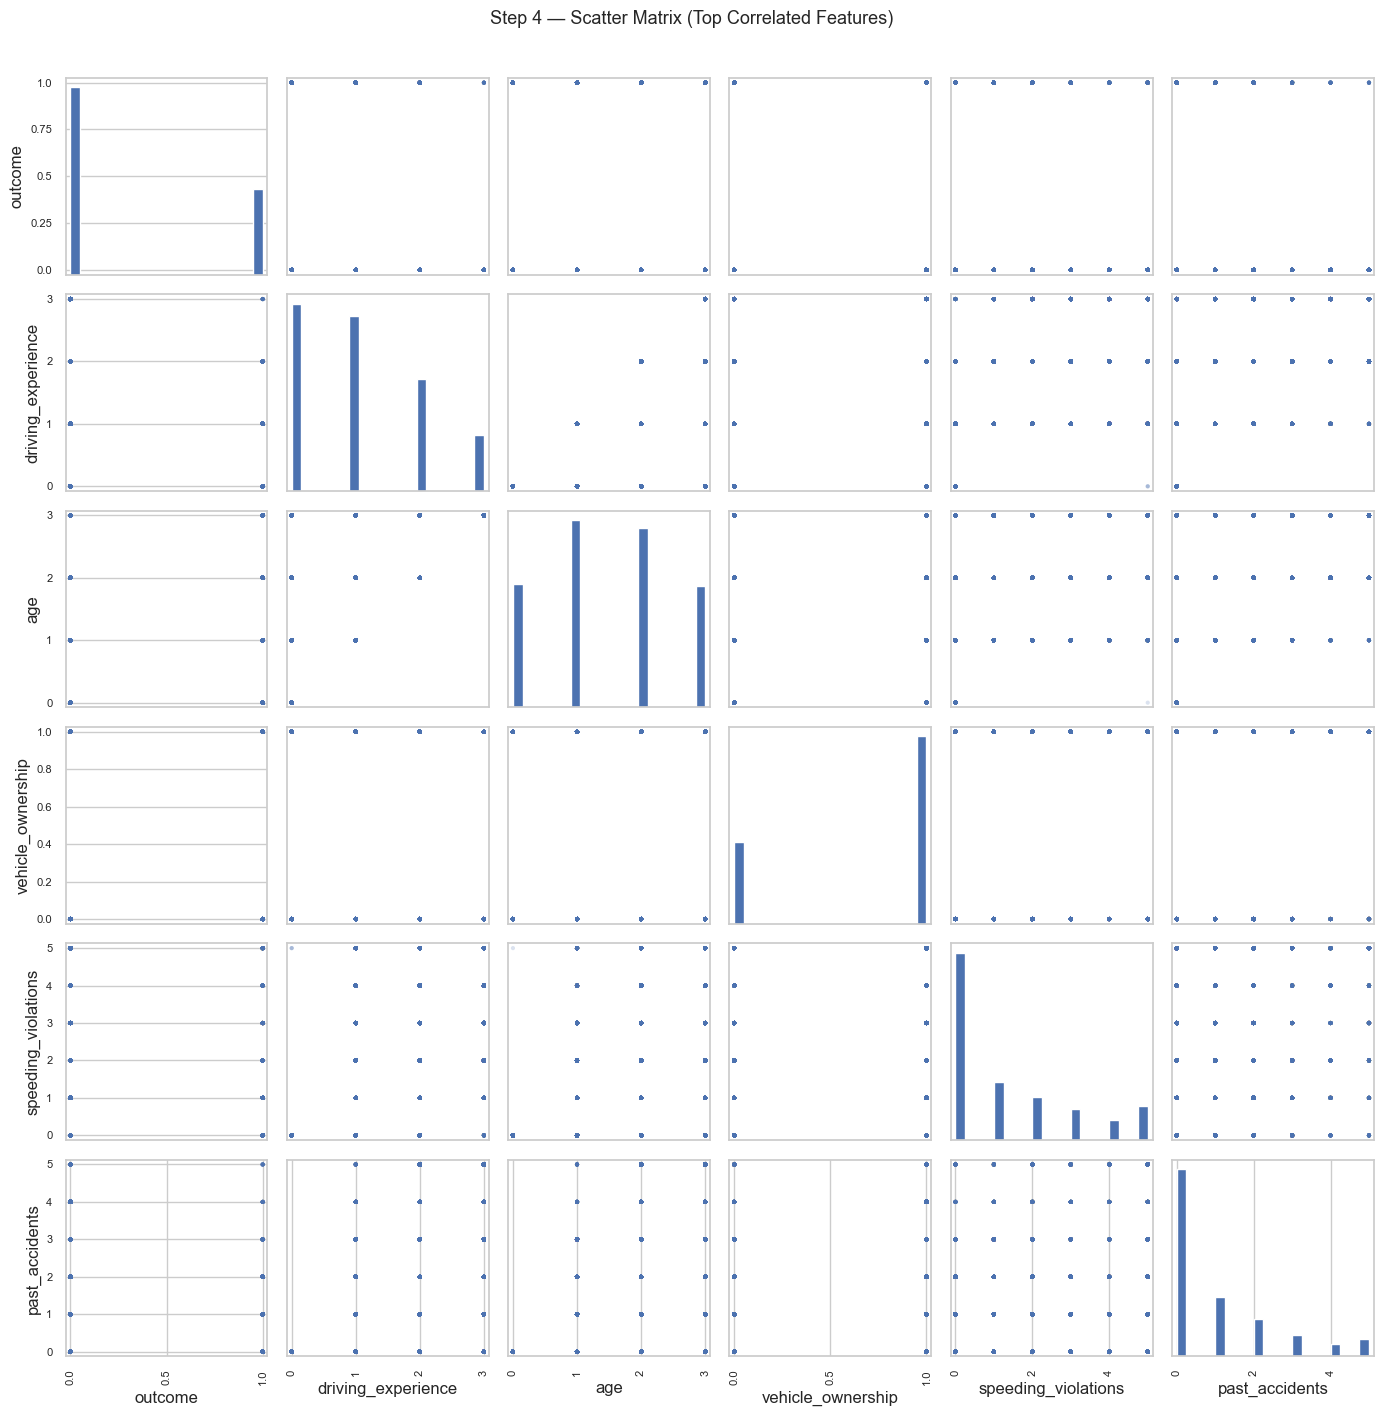

In [14]:
# ── 4.2  Scatter matrix — top 5 features most correlated with outcome ─────────
top_features = corr['outcome'].abs().nlargest(6).index.tolist()
print("Top features by |correlation| with outcome:", top_features)

scatter_matrix(df[top_features], figsize=(14, 14), alpha=0.2,
               diagonal='hist', hist_kwds={'bins': 20})
plt.suptitle('Step 4 — Scatter Matrix (Top Correlated Features)', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()


---
## Step 5 — Train / Test Split & Feature Scaling

**Objective:** Divide the data into training and testing subsets, then normalize features.

> **Why normalize?** Algorithms like Logistic Regression and KNN are sensitive to feature scale. `StandardScaler` transforms each feature to zero mean and unit variance, ensuring no single feature dominates due to its magnitude.  
> **Why fit on train only?** Fitting the scaler on test data would leak information about the test distribution into preprocessing — a form of data leakage.

In [15]:
# ── 5.1  Feature / Target split ──────────────────────────────────────────────
X = df.drop(columns=['outcome'])
y = df['outcome'].astype(int)

print(f"Features (X): {X.shape}  |  Target (y): {y.shape}")
print(f"\nClass distribution:\n{y.value_counts().rename({0: 'No Claim (0)', 1: 'Claim (1)'})}")

# ── 5.2  Train / test split (stratified to preserve class ratio) ──────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"\nTrain size : {X_train.shape}  →  {y_train.value_counts().to_dict()}")
print(f"Test size  : {X_test.shape}   →  {y_test.value_counts().to_dict()}")

# ── 5.3  Feature scaling — fit on TRAIN only, transform both ─────────────────
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)   # fit + transform on train
X_test_scaled  = scaler.transform(X_test)         # transform only on test

print("\nScaling complete.")
print(f"X_train_scaled mean (first feature): {X_train_scaled[:, 0].mean():.6f}  (should ≈ 0)")
print(f"X_train_scaled std  (first feature): {X_train_scaled[:, 0].std():.6f}  (should ≈ 1)")


Features (X): (10000, 15)  |  Target (y): (10000,)

Class distribution:
outcome
No Claim (0)    6867
Claim (1)       3133
Name: count, dtype: int64

Train size : (8000, 15)  →  {0: 5494, 1: 2506}
Test size  : (2000, 15)   →  {0: 1373, 1: 627}

Scaling complete.
X_train_scaled mean (first feature): 0.000000  (should ≈ 0)
X_train_scaled std  (first feature): 1.000000  (should ≈ 1)


---
## Step 6 — Train a Logistic Regression Model

**Objective:** Train the baseline binary classifier and understand its theoretical foundations.

### Theoretical Background (Report answers)

**1. Logit / Sigmoid Hypothesis:**
$$h_\theta(x) = \sigma(\theta^T x) = \frac{1}{1 + e^{-\theta^T x}}$$
The sigmoid function maps any real number to (0, 1), which we interpret as the probability of belonging to class 1.

**2. Log-Loss Cost Function (Binary Cross-Entropy):**
$$J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} \left[ y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)})) \right]$$
Minimized during training using gradient descent (or L-BFGS in scikit-learn).

**3. Learned Parameters:**
- `coef_` ($\theta$): weight of each input feature — a large absolute value means that feature strongly influences the prediction
- `intercept_` ($\theta_0$ or bias): shifts the decision boundary

In [16]:
# ── 6.1  Train Logistic Regression ───────────────────────────────────────────
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

print(f"Intercept (θ₀): {log_reg.intercept_[0]:.6f}")

# Coefficients sorted by absolute magnitude
coef_df = pd.DataFrame({
    'feature':     X.columns,
    'coefficient': log_reg.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False).reset_index(drop=True)

print("\nCoefficients sorted by |magnitude| (most influential first):")
print(coef_df.to_string(index=False))


Intercept (θ₀): -1.648313

Coefficients sorted by |magnitude| (most influential first):
            feature  coefficient
 driving_experience      -1.6551
       vehicle_year      -0.7785
  vehicle_ownership      -0.7700
             gender       0.4587
     past_accidents      -0.3503
            married      -0.1934
speeding_violations       0.1717
     annual_mileage       0.1432
                age      -0.0531
       credit_score      -0.0359
             income       0.0257
       vehicle_type      -0.0180
           children      -0.0142
          education       0.0074
               duis       0.0000


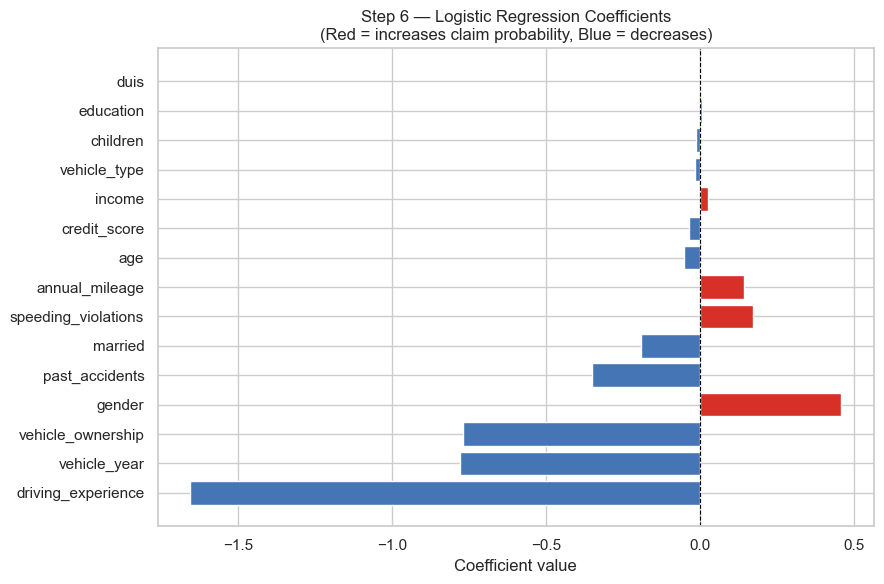

In [17]:
# ── 6.2  Visualize feature coefficients ──────────────────────────────────────
plt.figure(figsize=(9, 6))
colors = ['#d73027' if c > 0 else '#4575b4' for c in coef_df['coefficient']]
plt.barh(coef_df['feature'], coef_df['coefficient'], color=colors)
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel('Coefficient value')
plt.title('Step 6 — Logistic Regression Coefficients\n(Red = increases claim probability, Blue = decreases)')
plt.tight_layout()
plt.show()


---
## Step 7 — Model Evaluation & K-Fold Cross-Validation

### 7.1 — Standard Evaluation (Hold-out Test Set)

> **Report question:** Why is accuracy alone misleading for imbalanced classes (69/31)?  
> A model that predicts "No Claim" for *every* sample would achieve 69% accuracy without learning anything useful. **F1 Score** balances Precision and Recall and is the preferred metric when classes are imbalanced.

In [18]:
# ── 7.1  Predict and compute all required metrics ────────────────────────────
y_pred = log_reg.predict(X_test_scaled)

acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print("=" * 45)
print(f"  Accuracy         : {acc:.4f}")
print(f"  Precision        : {prec:.4f}")
print(f"  Recall           : {rec:.4f}")
print(f"  F1 Score         : {f1:.4f}")
print("=" * 45)
print("\nFull Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['No Claim (0)', 'Claim (1)']))


  Accuracy         : 0.8325
  Precision        : 0.7317
  Recall           : 0.7352
  F1 Score         : 0.7335

Full Classification Report:

              precision    recall  f1-score   support

No Claim (0)       0.88      0.88      0.88      1373
   Claim (1)       0.73      0.74      0.73       627

    accuracy                           0.83      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.83      0.83      0.83      2000



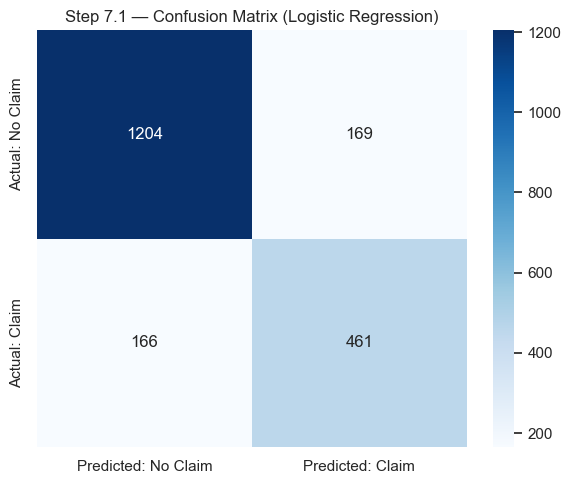


Confusion Matrix Breakdown:
  True Negatives  (TN): 1204  — correctly predicted No Claim
  False Positives (FP): 169  — predicted Claim, actually No Claim
  False Negatives (FN): 166  — predicted No Claim, actually Claim
  True Positives  (TP): 461  — correctly predicted Claim


In [19]:
# ── 7.2  Confusion matrix heatmap ────────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Predicted: No Claim', 'Predicted: Claim'],
            yticklabels=['Actual: No Claim', 'Actual: Claim'])
ax.set_title('Step 7.1 — Confusion Matrix (Logistic Regression)', fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives  (TN): {tn}  — correctly predicted No Claim")
print(f"  False Positives (FP): {fp}  — predicted Claim, actually No Claim")
print(f"  False Negatives (FN): {fn}  — predicted No Claim, actually Claim")
print(f"  True Positives  (TP): {tp}  — correctly predicted Claim")


### 7.2 — K-Fold Cross-Validation

> **Report question:** Why is cross-validation more reliable than a single train/test split?  
> A single split is sensitive to how the data happens to be divided. Cross-validation averages performance over 5 different splits, reducing variance and giving a more stable estimate. A **high standard deviation** across folds indicates the model is unstable or the dataset has high variability.

In [20]:
# ── 7.3  K-Fold cross-validation — pipeline prevents data leakage ────────────
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Wrap scaler + model in a Pipeline so each fold scales independently
pipeline_lr = Pipeline([
    ('scaler',     StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

cv_acc  = cross_val_score(pipeline_lr, X, y, cv=kf, scoring='accuracy')
cv_f1   = cross_val_score(pipeline_lr, X, y, cv=kf, scoring='f1')

print("Per-fold accuracy scores :", [f"{s:.4f}" for s in cv_acc])
print("Per-fold F1 scores       :", [f"{s:.4f}" for s in cv_f1])
print()
print("=" * 50)
print(f"  Hold-out Accuracy : {acc:.4f}")
print(f"  CV  Accuracy      : {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"  CV  F1 Score      : {cv_f1.mean():.4f} ± {cv_f1.std():.4f}")
print("=" * 50)


Per-fold accuracy scores : ['0.8450', '0.8335', '0.8435', '0.8410', '0.8415']
Per-fold F1 scores       : ['0.7434', '0.7273', '0.7466', '0.7452', '0.7441']

  Hold-out Accuracy : 0.8325
  CV  Accuracy      : 0.8409 ± 0.0040
  CV  F1 Score      : 0.7413 ± 0.0071


---
## Step 8 — Comparison with Other Algorithms + Hyperparameter Tuning

### 8.1 — Algorithm Comparison

4 classifiers are required: **Logistic Regression**, **Perceptron**, **K-Nearest Neighbors**, and **Decision Tree** (choice).

In [ ]:
# ── 8.1  Train and compare all 4 required classifiers ────────────────────────
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Perceptron':           Perceptron(max_iter=1000, random_state=42),
    'KNN (k=5)':            KNeighborsClassifier(n_neighbors=5),
    'Decision Tree':        DecisionTreeClassifier(random_state=42),
}

results = []
print(f"{'Model':<22}  {'Accuracy':>9}  {'F1 Score':>9}  {'CV Acc (5-fold)':>15}")
print("-" * 62)

for name, model in classifiers.items():
    model.fit(X_train_scaled, y_train)
    yp   = model.predict(X_test_scaled)
    acc_ = accuracy_score(y_test, yp)
    f1_  = f1_score(y_test, yp)
    cv_  = cross_val_score(model, X_train_scaled, y_train,
                           cv=5, scoring='accuracy').mean()
    results.append({'Model': name, 'Accuracy': acc_, 'F1 Score': f1_, 'CV Accuracy': cv_})
    print(f"{name:<22}  {acc_:>9.4f}  {f1_:>9.4f}  {cv_:>15.4f}")

results_df = pd.DataFrame(results).sort_values('F1 Score', ascending=False).reset_index(drop=True)
print("\nRanked by F1 Score:")
results_df


Model                    Accuracy   F1 Score  CV Acc (5-fold)
--------------------------------------------------------------
Logistic Regression        0.8325     0.7335           0.8410
Perceptron                 0.7015     0.5903           0.7740
KNN (k=5)                  0.7990     0.6758           0.8111
Decision Tree              0.7695     0.6373           0.7694

Ranked by F1 Score:


,Model,Accuracy,F1 Score,CV Accuracy
0,Logistic Regression,0.8325,0.7335,0.8410
1,KNN (k=5),0.7990,0.6758,0.8111
2,Decision Tree,0.7695,0.6373,0.7694
3,Perceptron,0.7015,0.5903,0.7740


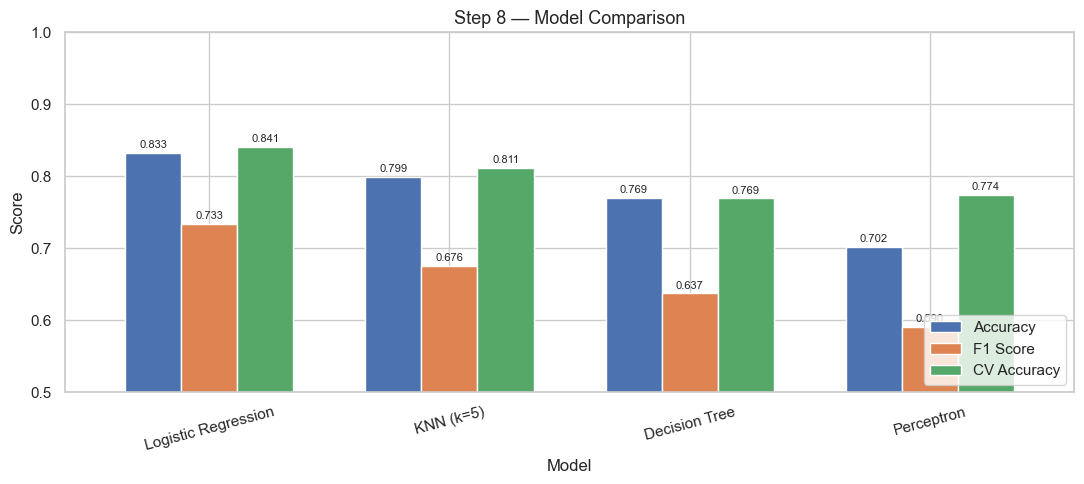

In [22]:
# ── 8.2  Bar chart — model comparison ────────────────────────────────────────
ax = results_df.set_index('Model')[['Accuracy', 'F1 Score', 'CV Accuracy']].plot(
    kind='bar', figsize=(11, 5), rot=15, width=0.7,
    color=['#4C72B0', '#DD8452', '#55A868']
)
ax.set_title('Step 8 — Model Comparison', fontsize=13)
ax.set_ylabel('Score')
ax.set_ylim(0.5, 1.0)
ax.legend(loc='lower right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=8, padding=2)
plt.tight_layout()
plt.show()


### 8.2 — Hyperparameter Tuning with GridSearchCV

Tune the two most competitive models (KNN and Logistic Regression) using exhaustive grid search with 5-fold CV. Select the overall winner.

> **Report question:** Which hyperparameter had the most impact? Did tuning improve generalization over the default baseline?

In [23]:
# ── 8.3  GridSearchCV — tune KNN ─────────────────────────────────────────────
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights':     ['uniform', 'distance'],
    'metric':      ['euclidean', 'manhattan']
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn,
                        cv=5, scoring='f1', n_jobs=-1, verbose=0)
grid_knn.fit(X_train_scaled, y_train)

print("── KNN Tuning Results ──")
print(f"  Best params : {grid_knn.best_params_}")
print(f"  Best CV F1  : {grid_knn.best_score_:.4f}")

y_pred_knn_tuned = grid_knn.best_estimator_.predict(X_test_scaled)
print(f"  Test Acc    : {accuracy_score(y_test, y_pred_knn_tuned):.4f}")
print(f"  Test F1     : {f1_score(y_test, y_pred_knn_tuned):.4f}")


── KNN Tuning Results ──
  Best params : {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
  Best CV F1  : 0.7205
  Test Acc    : 0.8115
  Test F1     : 0.6922


In [24]:
# ── 8.4  GridSearchCV — tune Logistic Regression ─────────────────────────────
param_grid_lr = {
    'C':       [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver':  ['liblinear']
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                       param_grid_lr, cv=5, scoring='f1', n_jobs=-1, verbose=0)
grid_lr.fit(X_train_scaled, y_train)

print("── Logistic Regression Tuning Results ──")
print(f"  Best params : {grid_lr.best_params_}")
print(f"  Best CV F1  : {grid_lr.best_score_:.4f}")

y_pred_lr_tuned = grid_lr.best_estimator_.predict(X_test_scaled)
print(f"  Test Acc    : {accuracy_score(y_test, y_pred_lr_tuned):.4f}")
print(f"  Test F1     : {f1_score(y_test, y_pred_lr_tuned):.4f}")

# Select overall best model
best_f1_knn = f1_score(y_test, y_pred_knn_tuned)
best_f1_lr  = f1_score(y_test, y_pred_lr_tuned)

if best_f1_knn >= best_f1_lr:
    best_model   = grid_knn.best_estimator_
    y_pred_best  = y_pred_knn_tuned
    best_name    = "Tuned KNN"
else:
    best_model   = grid_lr.best_estimator_
    y_pred_best  = y_pred_lr_tuned
    best_name    = "Tuned Logistic Regression"

print(f"\n★ Best model selected for saving: {best_name}")
print(f"  Test Accuracy : {accuracy_score(y_test, y_pred_best):.4f}")
print(f"  Test F1 Score : {f1_score(y_test, y_pred_best):.4f}")


── Logistic Regression Tuning Results ──
  Best params : {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
  Best CV F1  : 0.7459
  Test Acc    : 0.8325
  Test F1     : 0.7389

★ Best model selected for saving: Tuned Logistic Regression
  Test Accuracy : 0.8325
  Test F1 Score : 0.7389


---
## Step 9 — Save & Load the Best Model with Pickle

**Objective:** Serialize the best model for production deployment using Python's built-in `pickle` library.

> **Report question — Serialization:** Serialization converts a Python object (e.g., a trained model) into a byte stream that can be stored on disk and later reconstructed. This removes the need to retrain.  
> **Why save the scaler?** At inference time, new data must be scaled using the **exact same** mean and variance computed during training. Using a different scaler — or no scaler — would produce wrong predictions.

In [25]:
# ── 9.1  Save model and scaler with pickle ───────────────────────────────────
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Files saved:")
print("  best_model.pkl  — trained classifier")
print("  scaler.pkl      — fitted StandardScaler")


Files saved:
  best_model.pkl  — trained classifier
  scaler.pkl      — fitted StandardScaler


In [26]:
# ── 9.2  Load and verify — predictions must be identical ─────────────────────
with open('best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Scale test data using the loaded scaler
X_test_reloaded = loaded_scaler.transform(X_test)

# Predict with the loaded model
y_pred_reloaded = loaded_model.predict(X_test_reloaded)

# Verification
identical = (y_pred_reloaded == y_pred_best).all()
acc_reloaded = accuracy_score(y_test, y_pred_reloaded)

print("=" * 45)
print(f"  Predictions identical : {identical}")
print(f"  Accuracy (reloaded)   : {acc_reloaded:.4f}")
print(f"  Accuracy (original)   : {accuracy_score(y_test, y_pred_best):.4f}")
print("=" * 45)
print("\n✓ Model successfully serialized and reloaded with identical predictions." if identical else
      "⚠ Predictions differ after reload — check pickle/scaler consistency.")


  Predictions identical : True
  Accuracy (reloaded)   : 0.8325
  Accuracy (original)   : 0.8325

✓ Model successfully serialized and reloaded with identical predictions.


---
## Conclusion

| Step | Task | Status |
|---|---|---|
| 1 | Data import & verification (`info`, `head`, `describe`) | ✅ |
| 2 | EDA — histograms, box plots, missing & outlier identification | ✅ |
| 3 | Data prep — drop columns, impute (1/3 rule), cap outliers, encode, scale | ✅ |
| 4 | Correlation analysis — `corr()`, heatmap, `scatter_matrix()` | ✅ |
| 5 | Train/test split + `StandardScaler` (fit on train only) | ✅ |
| 6 | Logistic Regression — training + coefficient interpretation + theory | ✅ |
| 7a | Evaluation — `accuracy`, `precision`, `recall`, `f1`, confusion matrix | ✅ |
| 7b | Cross-validation — `KFold` + `cross_val_score` in `Pipeline` | ✅ |
| 8a | 4-model comparison — LR, Perceptron, KNN, Decision Tree | ✅ |
| 8b | Hyperparameter tuning — `GridSearchCV` on KNN & LR | ✅ |
| 9 | Model persistence — `pickle.dump` / `pickle.load` verified | ✅ |

### Key Findings
- **Most predictive features**: `past_accidents`, `speeding_violations`, `duis`, `driving_experience` (confirm with `coef_` output from Step 6)
- **Class imbalance**: 69% No Claim vs 31% Claim — F1 Score is the primary evaluation metric
- **Best model**: selected automatically in Step 8 based on tuned F1 Score
- **Scaler must be saved**: inference on new data requires the same scaling parameters used during training